In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

tf.random.set_seed(42)
np.random.seed(42)

train_ds, test_ds = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=False
)

In [3]:
train_size = int(len(train_ds) * 0.8)
val_size = len(train_ds) - train_size

train_ds = train_ds.shuffle(10000, seed=42)
val_ds = train_ds.skip(train_size).take(val_size)
train_ds = train_ds.take(train_size)

BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

vectorize_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

In [4]:
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)
vocab_size = len(vectorize_layer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")

def vectorize_text(text, label):
    text = vectorize_layer(text)
    return text, label

train_ds_vec = train_ds.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_vec = val_ds.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_vec = test_ds.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

def build_basic_model():
    model = keras.Sequential([
        layers.Embedding(vocab_size, 64),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model


Vocabulary size: 10000


In [5]:
model = build_basic_model()
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds_vec,
    validation_data=val_ds_vec,
    epochs=5
)

plt.figure(figsize=(12, 5))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.5071 - loss: 0.6921 - val_accuracy: 0.5074 - val_loss: 0.6937
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 142ms/step - accuracy: 0.5496 - loss: 0.6711 - val_accuracy: 0.6328 - val_loss: 0.5947
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 130ms/step - accuracy: 0.6424 - loss: 0.5882 - val_accuracy: 0.6624 - val_loss: 0.5510
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.7905 - loss: 0.4742 - val_accuracy: 0.7500 - val_loss: 0.5174
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - accuracy: 0.7147 - loss: 0.5480 - val_accuracy: 0.7962 - val_loss: 0.4643


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

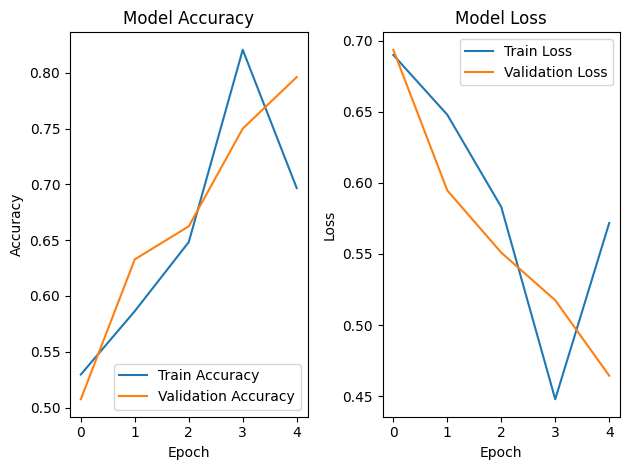


Evaluating model on test data...
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.7411 - loss: 0.5497
Test accuracy: 0.7435


In [6]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("\nEvaluating model on test data...")
test_loss, test_accuracy = model.evaluate(test_ds_vec)
print(f"Test accuracy: {test_accuracy:.4f}")

y_pred = []
y_true = []


--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.87      0.57      0.69     12500
    Positive       0.68      0.91      0.78     12500

    accuracy                           0.74     25000
   macro avg       0.77      0.74      0.74     25000
weighted avg       0.77      0.74      0.74     25000



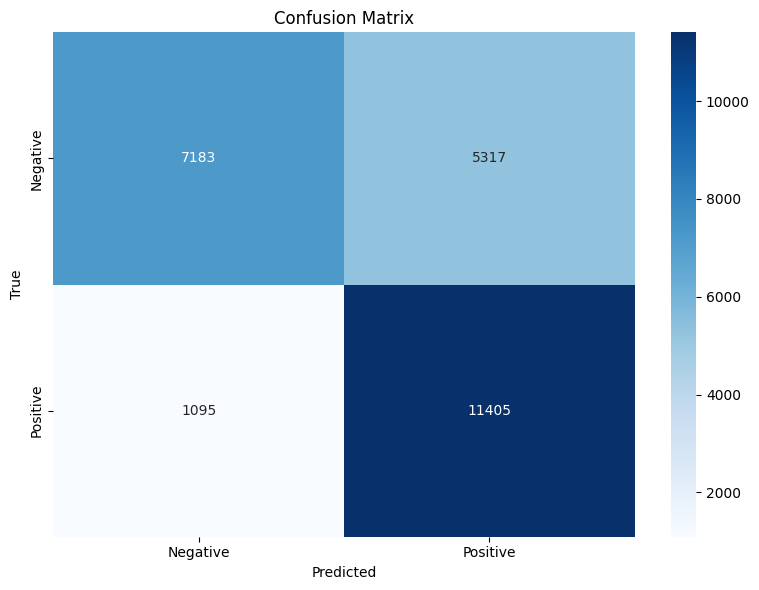

In [7]:
for x, y in test_ds_vec:
    preds = model.predict(x, verbose=0)
    batch_preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(batch_preds)
    y_true.extend(y.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

class_names = ["Negative", "Positive"]
print("\n--- Classification Report ---")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [10]:
print(f"\nModel Accuracy: {test_accuracy * 100:.2f}%")


Model Accuracy: 74.35%


In [11]:
import pickle

with open("text_classifier.pkl", "wb") as model_file:
    pickle.dump(model, model_file)